In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
import collections
import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib

from random import random

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_csv("sales_technical_test.csv") 

In [4]:
df.head()


,timestamp,tot,storeId
0,2017-01-01,132,1
1,2017-01-02,176,1
2,2017-01-03,128,1
3,2017-01-04,137,1
4,2017-01-05,109,1


In [5]:
df['time']=df.timestamp.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

2 magasins sans aucune autre variable que le total des ventes/jour et le jour correspondant >>> Mieux vaut faire une analyse séparée pour chacun des deux magasins.

# Analyse pour magasin 1

In [6]:
data1_ts = pd.Series(np.array(df[(df['storeId']==1)].tot), index=df[(df['storeId']==1)].time)

Il semble s'agir d'une série temporelle stationaire; de par sa nature (ventes d'un magasin, "ne peuvent pas augmenter à l'infini"), d'autre part comme semble l'indiquer le graph ci-dessous + le test de Dickey-fuller. C'est rassurant :)

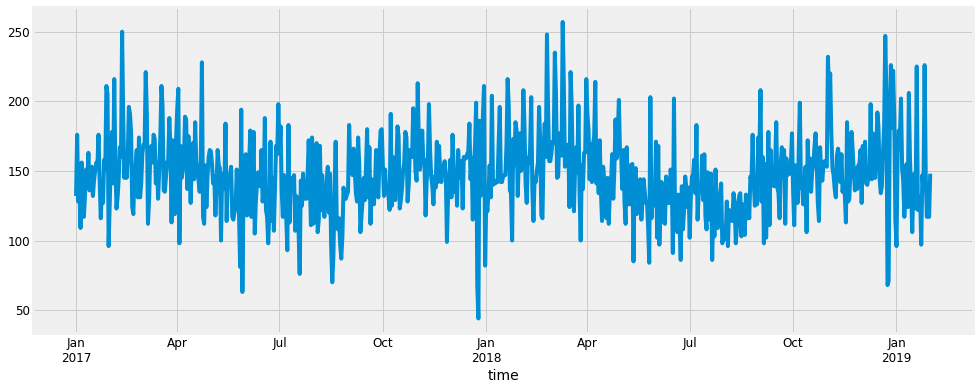

In [7]:
data1_ts.plot(figsize=(15, 6))
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
dickey=adfuller(data1_ts)
print("H_0 : Le processus est non-stationnaire")
print('ADF Statistic: %f' % dickey[0])
print('p-value: %f' % dickey[1])
print('Critical Values:')
for key, value in dickey[4].items():
	print('\t%s: %.3f' % (key, value))


H_0 : Le processus est non-stationnaire
ADF Statistic: -3.003577
p-value: 0.034562
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


Cependant il semble y avoir une composante de saisonnalité! (ventes plus hautes en avril qu'en Juillet).
La décomposition ci-après indique ine absence de 'trend' et une forte saisonnalité de périodicité environ équivalente à quatre par mois. Soit environ d'une semaine.

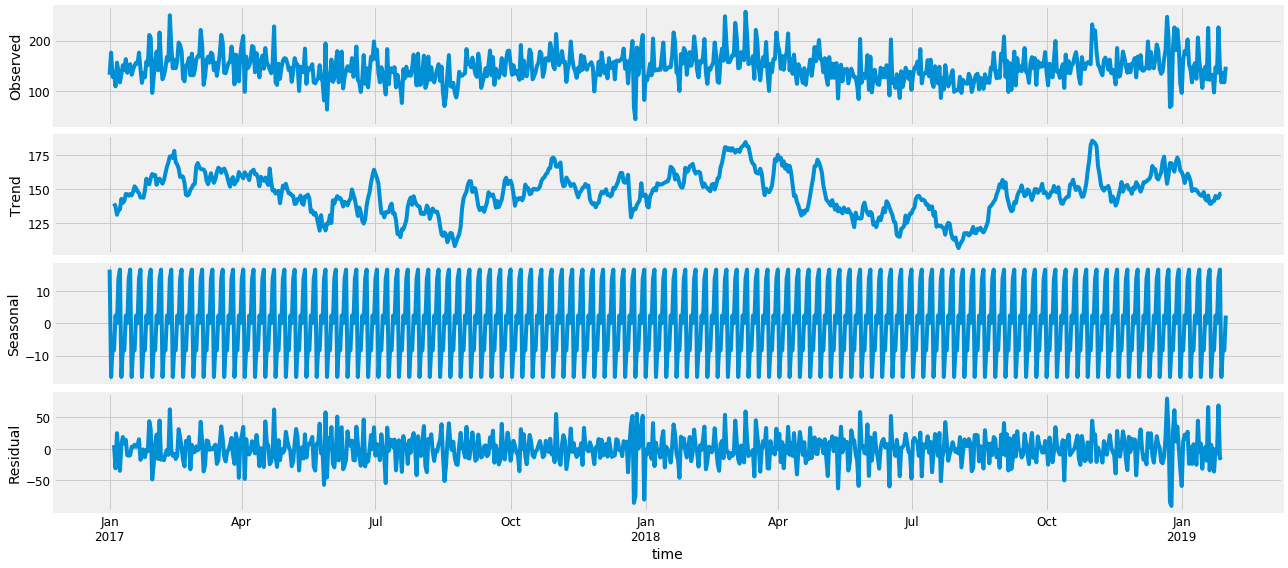

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(data1_ts, model='additive')
fig = decomposition.plot()
plt.show()

### ARMA modèle

Juste pour "s'amuser", je fit un modèle ARMA pour confirmer que les résidus sont corrélés à l'ordre 7, ce qui confirmerait cette saisonnalité d'une semaine...

In [11]:
mod = sm.tsa.statespace.SARIMAX(data1_ts,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0,0, 365),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

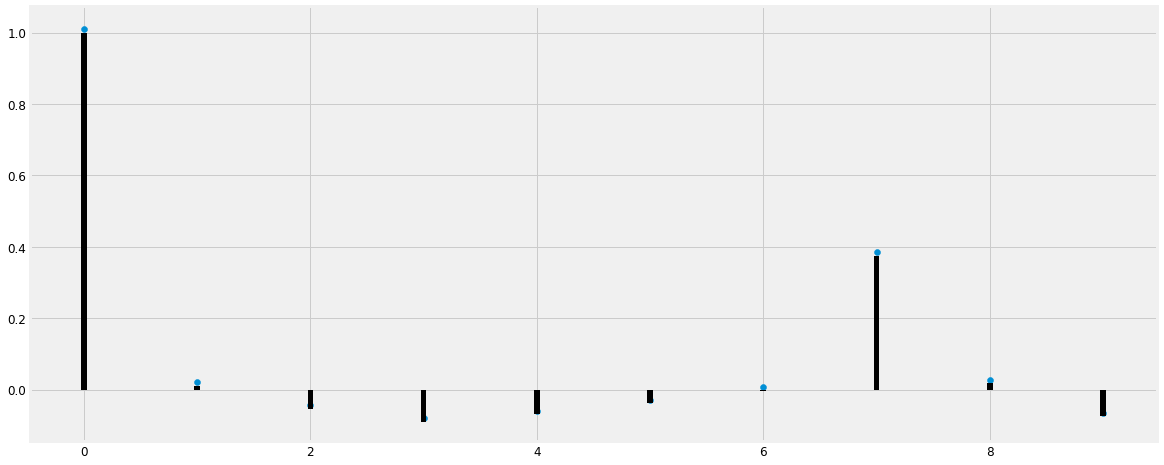

In [12]:
autoco=np.zeros(10)
for i in range(10):
    autoco[i]=results.resid.autocorr(lag=i)
plt.bar(np.arange(10), autoco,width=0.05,color='black')
plt.scatter(np.arange(10),autoco+0.01)

Le plot au-dessus confirme notre suspicion ! Dans un futur modèle, il sera judicieux d'inclure les lags $x_{t-1}$,...,$x_{t-7}$

## Régression linéaire inspirée d'un AR(7)

En tenant compte des observations précédentes, je vais d'abord fitter un modèle très simple de régression linéaire. J'y incluerai 7 lags $x_{t-1}$,...,$x_{t-7}$, une variable correspondant au mois de l'année, une variable correspondant au jour de la semaine, une variable gilet jaune (sait-on jamais). 
Inclure une variable météo aurait été très intéressant mais je ne connais pas la localisation des magasins/restaurants. Néanmoins, ces informations devraient être capturées partiellement par les variables correspondant au mois.
De même, ne connaissant pas la localisation, je n'inclus pas de variable pour les vacances scolaires dépendant de la zone A,B,C. Néanmoins, les variables juillet et août devraient prendre en compte les vacances d'été et j'inclus également une variable pour les vacances de noël qui elles sont communes à tous.

In [13]:
df = pd.read_csv("sales_technical_test.csv") 
df['time']=df.timestamp.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [14]:
data1 = {'tot': np.array(df[(df['storeId']==1)].tot)}
data1 = pd.DataFrame(data1, index=df[(df['storeId']==1)].time)

In [15]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months=['January', 'February','March', 'April','May', 'June','July', 'August','September', 'October',
        'November', 'December']
for i, x in enumerate(days):
    data1[x] = (data1.index.get_level_values(0).weekday == i).astype(int)
for i, x in enumerate(months):
    data1[x] = (data1.index.get_level_values(0).month == i+1).astype(int)

### Effet des 7 derniers jours

In [16]:
data1["lag1"]=data1['tot'].shift(1)
data1["lag2"]=data1['tot'].shift(2)
data1["lag3"]=data1['tot'].shift(3)
data1["lag4"]=data1['tot'].shift(4)
data1["lag5"]=data1['tot'].shift(5)
data1["lag6"]=data1['tot'].shift(6)
data1["lag7"]=data1['tot'].shift(7)

In [17]:
data1 = data1.iloc[7:]

### Effet vacances/fêtes de fin d'année

In [18]:
data1['noel']=((data1.index.get_level_values(0).day >= 19) & (data1.index.get_level_values(0).day <= 31) &
               (data1.index.get_level_values(0).month == 12))*1

### Effet gilets jaunes ? :)

In [19]:
data1["gilet"]=((data1.index.get_level_values(0).weekday == 5) & 
       (((data1.index.get_level_values(0).month == 11)&(data1.index.get_level_values(0).day >= 17)) | (data1.index.get_level_values(0).month == 12)) &
       (data1.index.get_level_values(0).year == 2018)|
      ((data1.index.get_level_values(0).weekday == 5) & (data1.index.get_level_values(0).year == 2019)))*1

In [20]:
data1

,tot,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,January,February,...,December,lag1,lag2,lag3,lag4,lag5,lag6,lag7,noel,gilet
time,,,,,,,,,,,,,,,,,,,,,
2017-01-08,117,0,0,0,0,0,0,1,1,0,...,0,139.0,156.0,109.0,137.0,128.0,176.0,132.0,0,0
2017-01-09,133,1,0,0,0,0,0,0,1,0,...,0,117.0,139.0,156.0,109.0,137.0,128.0,176.0,0,0
2017-01-10,151,0,1,0,0,0,0,0,1,0,...,0,133.0,117.0,139.0,156.0,109.0,137.0,128.0,0,0
2017-01-11,141,0,0,1,0,0,0,0,1,0,...,0,151.0,133.0,117.0,139.0,156.0,109.0,137.0,0,0
2017-01-12,163,0,0,0,1,0,0,0,1,0,...,0,141.0,151.0,133.0,117.0,139.0,156.0,109.0,0,0
2017-01-13,136,0,0,0,0,1,0,0,1,0,...,0,163.0,141.0,151.0,133.0,117.0,139.0,156.0,0,0
2017-01-14,148,0,0,0,0,0,1,0,1,0,...,0,136.0,163.0,141.0,151.0,133.0,117.0,139.0,0,0
2017-01-15,153,0,0,0,0,0,0,1,1,0,...,0,148.0,136.0,163.0,141.0,151.0,133.0,117.0,0,0
2017-01-16,132,1,0,0,0,0,0,0,1,0,...,0,153.0,148.0,136.0,163.0,141.0,151.0,133.0,0,0


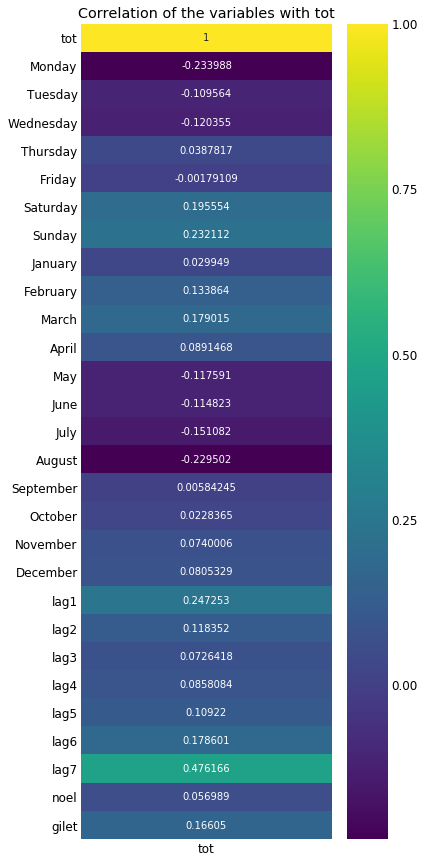

In [18]:
import seaborn as sns
plt.figure(figsize = (5,15))
sns.heatmap(pd.DataFrame(data1.corr()["tot"]),annot=True, fmt="g", cmap='viridis')
plt.title("Correlation of the variables with tot")
plt.show()

Quelques correlations intéressantes : moins d'activité en été qu'au printemps. Plus d'activité le week-end, moins le lundi et le mardi. Un effet positif des gilets jaunes.

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
lm = LinearRegression()
lm.fit(data1.drop('tot', axis=1),data1['tot'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
model=sm.OLS(data1['tot'],data1.drop('tot', axis=1)).fit()

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tot   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     15.95
Date:                Sun, 31 Mar 2019   Prob (F-statistic):           4.19e-55
Time:                        13:17:36   Log-Likelihood:                -3441.7
No. Observations:                 754   AIC:                             6937.
Df Residuals:                     727   BIC:                             7062.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Monday        51.4010      8.702      5.907      0.000      34.317      68.485
Tuesday       62.3090      8.695      7.166      0.000      45.239      79.379
Wednesday     60.5421      8.708      6.953      0.000      43.447      77.638
Thursday      68.4387      8.712      7.855      0.000      51.334      85.543
Friday        65.6659      8.713      7.536      0.000      48.560      82.772
Saturday      74.5456      8.740      8.529      0.000      57.387      91.704
Sunday        76.5564      8.743      8.757      0.000      59.392      93.720
January       40.1940      5.712      7.037      0.000      28.980      51.408
February      48.4860      6.816      7.114      0.000      35.105      61.867
March         50.1967      7.111      7.059      0.000      36.235      64.158
April         44.2499      6.392      6.923      0.000      31.701      56.799
May           29.3736      5.167      5.684      0.000      19.229      39.518
June          31.0333      4.671      6.644      0.000      21.864      40.203
July          27.4656      4.773      5.755      0.000      18.096      36.835
August        23.1197      4.003      5.776      0.000      15.262      30.978
September     39.3846      5.532      7.119      0.000      28.524      50.246
October       40.7992      5.880      6.939      0.000      29.256      52.343
November      42.2687      6.425      6.579      0.000      29.654      54.883
December      42.8874      6.488      6.610      0.000      30.150      55.624
lag1           0.1017      0.036      2.841      0.005       0.031       0.172
lag2          -0.0095      0.036     -0.264      0.792      -0.080       0.061
lag3          -0.0263      0.036     -0.732      0.464      -0.097       0.044
lag4           0.0094      0.036      0.261      0.794      -0.061       0.080
lag5          -0.0103      0.036     -0.287      0.774      -0.081       0.060
lag6          -0.0209      0.036     -0.578      0.564      -0.092       0.050
lag7           0.2476      0.036      6.858      0.000       0.177       0.319
noel          -1.4094      6.110     -0.231      0.818     -13.405      10.586
gilet         19.1019      7.784      2.454      0.014       3.819      34.385
==============================================================================
Omnibus:                       22.242   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.901
Skew:                          -0.134   Prob(JB):                     1.78e-10
Kurtosis:                       4.165   Cond. No.                     6.17e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.02e-26. This might indic

Le tableau de régression rend plus ou moins les mêmes conclusions que le tableau de correlation. $R^2$ pas terrible (0.36). En revanche les résidus n'ont plus d'autocorrelation à l'ordre 7 (cf ci-dessous) : inclure les lags semble avoir marché.

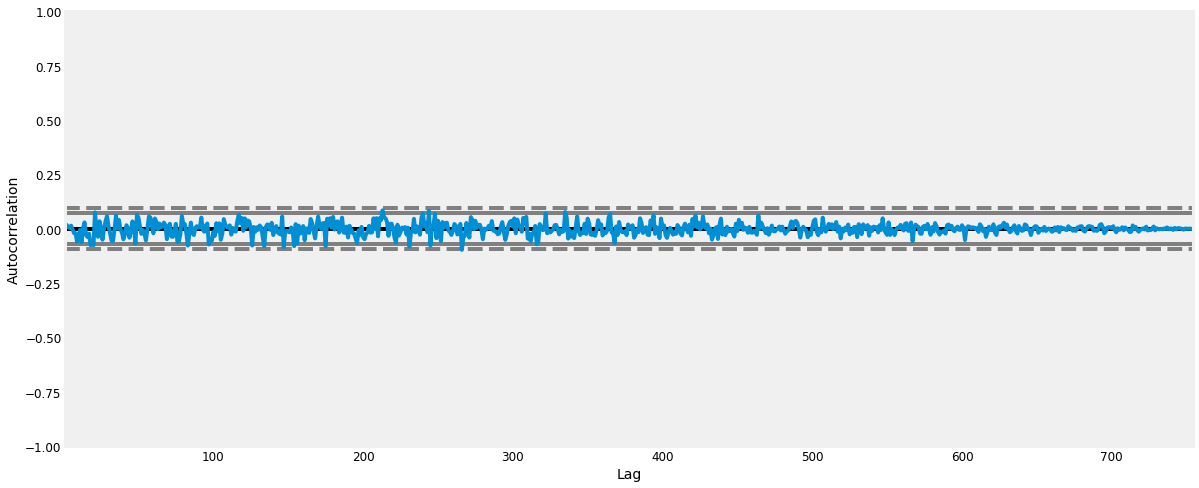

In [22]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(model.resid)

## Fit et prédiction pour le model 1

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data1.drop("tot",1), data1.tot, test_size=0.2)

In [24]:
lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

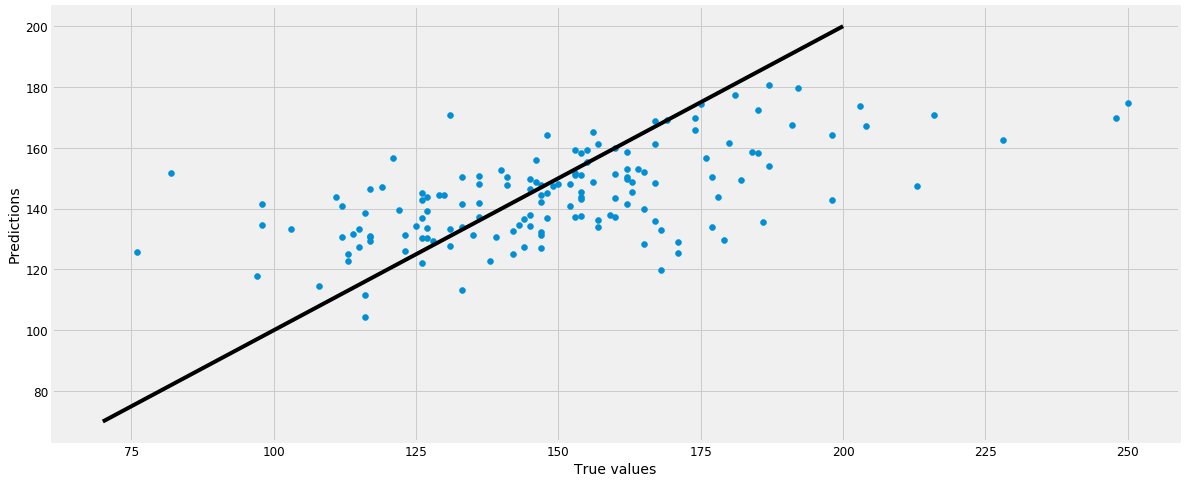

In [25]:
plt.scatter(y_test, predictions)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.plot([70, 200], [70, 200], 'k-')

Prédiction pas si mauvaise étant donné le peu de variables explicatives à disposition...

In [26]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [27]:
evaluate(lm,X_test,y_test)

Model Performance
Average Error: 17.6404 degrees.
Accuracy = 88.02%.


88.02075233454863

## Random Forest

Passons maintenant aux choses sérieuses : une random forest. On commence par un model naïf sans tuning :

In [28]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 2000, random_state = 42)

rf.fit(X_train, y_train);

/Users/Adrien/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [29]:
pred2 = rf.predict(X_test)

In [30]:
errors = abs(pred2 - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Mean Absolute Error: 18.16 degrees.
Accuracy: 87.56 %.


Ce n'est pas si mal. Passons maintenat un une 3-fold cross validation

### Cross validation pour random forest

In [31]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [32]:
rf = RandomForestRegressor()

rf_random1 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random1.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   1.3s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   1.3s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 


[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   2.5s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.0s


[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=   9.6s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   2.7s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=   9.2s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   5.6s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators

[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total=   6.4s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=   4.9s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=   4.9s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=  10.3s
[CV] n_estimators=

[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   2.9s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   2.9s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=   3.6s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   7.1s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800,

[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   1.6s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   4.0s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   3.9s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   3.8s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=400, 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.4min


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   5.3s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   5.5s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=  11.9s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=  11.8s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimat

[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, total=   6.4s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   8.6s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   5.7s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   8.9s
[CV] n_est

[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total=   3.6s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   1.5s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   1.2s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   1.5s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=

[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=   3.1s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   2.2s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   1.4s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   1.3s
[CV] n_estimators=1600, min

[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   1.5s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   1.8s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   8.0s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   8.4s
[CV] n_estimators=2000

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.1min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

Hyper-paramètres optimaux :

In [33]:
rf_random1.best_params_

{'bootstrap': False,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [34]:
best_random = rf_random1.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 17.9603 degrees.
Accuracy = 87.70%.


In [35]:
model_final1=rf_random1.best_estimator_.fit(data1.drop("tot",1), data1.tot,)

In [36]:
od = collections.OrderedDict()

od["tot"]=[0]*28
for i in days :
    od[i]=[0]*28
for i in months :
    od[i]=[0]*28
for i in range(7):
    od["lag"+str(i+1)]=[0]*28
od["noel"]=[0]*28
od["gilet"]=[0]*28
od["February"]=[1]*28
x=pd.DataFrame(od)
x.iloc[0]["Friday"]=1
for i in range(np.array(x).shape[0]-1):
    for j in range(np.array(days).shape[0]):
        if x.iloc[i][days[j]]==1:
            x.iloc[i+1][days[(j+1)%7]]=1
x.gilet=(x.Saturday==1)*1

In [37]:
data11=data1.copy()
data11=data11.append(x)

In [42]:
init=754
for j in range(28):
    for i in range(7):
        data11.iloc[init+j,20+i]=data11.iloc[init+j-i-1,0]
    data11.iloc[init+j,0]=model_final1.predict(data11.iloc[init+j,1:29].reshape(1, -1))
    

In [43]:
data11

,tot,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,January,February,...,December,lag1,lag2,lag3,lag4,lag5,lag6,lag7,noel,gilet
2017-01-08 00:00:00,117.000000,0,0,0,0,0,0,1,1,0,...,0,139.000000,156.000000,109.000000,137.000000,128.000000,176.000000,132.000000,0,0
2017-01-09 00:00:00,133.000000,1,0,0,0,0,0,0,1,0,...,0,117.000000,139.000000,156.000000,109.000000,137.000000,128.000000,176.000000,0,0
2017-01-10 00:00:00,151.000000,0,1,0,0,0,0,0,1,0,...,0,133.000000,117.000000,139.000000,156.000000,109.000000,137.000000,128.000000,0,0
2017-01-11 00:00:00,141.000000,0,0,1,0,0,0,0,1,0,...,0,151.000000,133.000000,117.000000,139.000000,156.000000,109.000000,137.000000,0,0
2017-01-12 00:00:00,163.000000,0,0,0,1,0,0,0,1,0,...,0,141.000000,151.000000,133.000000,117.000000,139.000000,156.000000,109.000000,0,0
2017-01-13 00:00:00,136.000000,0,0,0,0,1,0,0,1,0,...,0,163.000000,141.000000,151.000000,133.000000,117.000000,139.000000,156.000000,0,0
2017-01-14 00:00:00,148.000000,0,0,0,0,0,1,0,1,0,...,0,136.000000,163.000000,141.000000,151.000000,133.000000,117.000000,139.000000,0,0
2017-01-15 00:00:00,153.000000,0,0,0,0,0,0,1,1,0,...,0,148.000000,136.000000,163.000000,141.000000,151.000000,133.000000,117.000000,0,0
2017-01-16 00:00:00,132.000000,1,0,0,0,0,0,0,1,0,...,0,153.000000,148.000000,136.000000,163.000000,141.000000,151.000000,133.000000,0,0
2017-01-17 00:00:00,143.000000,0,1,0,0,0,0,0,1,0,...,0,132.000000,153.000000,148.000000,136.000000,163.000000,141.000000,151.000000,0,0


In [45]:
from datetime import date
from datetime import timedelta
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months=['January', 'February','March', 'April','May', 'June','July', 'August','September', 'October',
        'November', 'December']
a = date(2019,2,1)
numdays = 28
dateList = []
for x in range (0, numdays):
    dateList.append(a + timedelta(days = x))

In [64]:
out1 = collections.OrderedDict()
out1["tot"]=np.array(data11.iloc[754:,0])
out1["storeId"]=np.ones(np.array(data11.iloc[754:,0]).shape[0])

In [65]:
out1=pd.DataFrame(out1,index=dateList)
out1.index.name='timestamp'

In [66]:
out1.to_csv(r'magasin1.csv')

# Deuxième magasin

A priori, l'analyse sera extrêmement similaire à celle que j'ai faite pour le magasin numéro 1...

In [67]:
data2_ts = pd.Series(np.array(df[(df['storeId']==2)].tot), index=df[(df['storeId']==2)].time)

Il semble encore s'agir d'une série temporelle stationaire comme semble l'indiquer le graph ci-dessous + le test de Dickey-fuller. De plus, il semble y avoir moins de 'trend' été vs printemps comparé au magasin 1

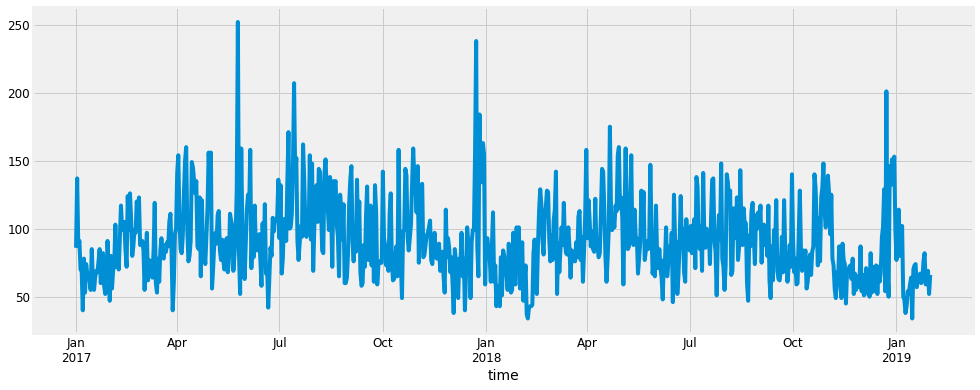

In [68]:
data2_ts.plot(figsize=(15, 6))
plt.show()

In [69]:
from statsmodels.tsa.stattools import adfuller
dickey=adfuller(data2_ts)
print("H_0 : Le processus est non-stationnaire")
print('ADF Statistic: %f' % dickey[0])
print('p-value: %f' % dickey[1])
print('Critical Values:')
for key, value in dickey[4].items():
	print('\t%s: %.3f' % (key, value))


H_0 : Le processus est non-stationnaire
ADF Statistic: -4.786811
p-value: 0.000058
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


Encore une fois, une forte saisonnalité de périodicité environ équivalente à quatre par mois. Soit environ d'une semaine. Cependant cette fois on ne voit presque pas de 'trend' été vs printemps.

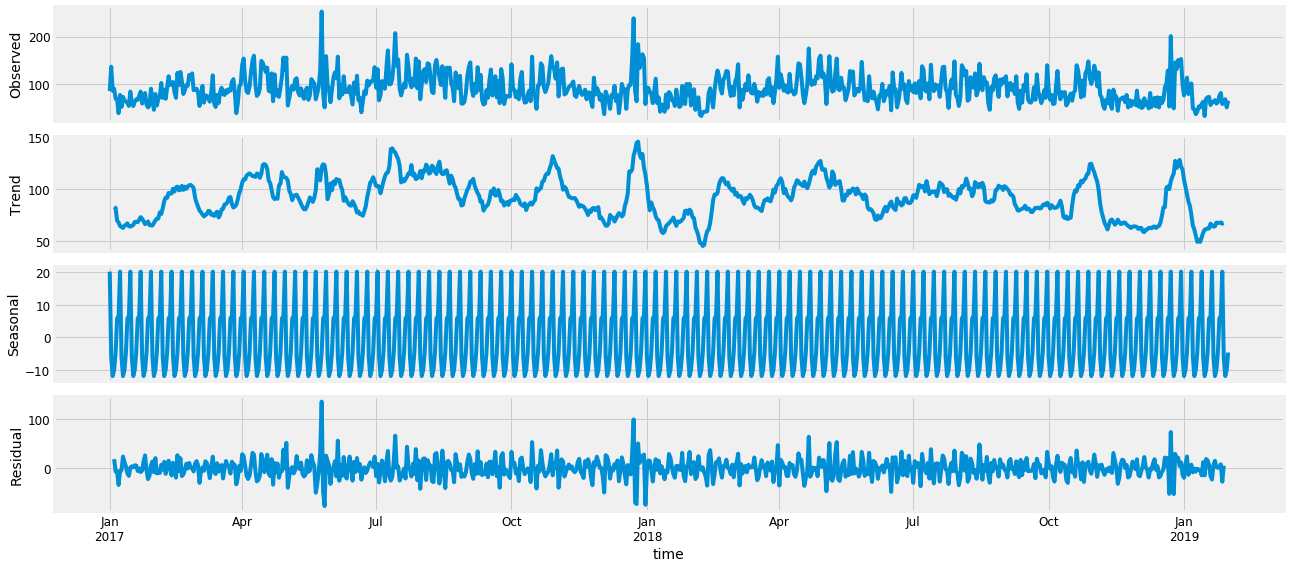

In [70]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(data2_ts, model='additive')
fig = decomposition.plot()
plt.show()

### ARMA modèle

Juste pour "s'amuser", je fit un modèle ARMA pour confirmer que les résidus sont corrélés à l'ordre 7, ce qui confirmerait cette saisonnalité d'une semaine...

In [71]:
mod = sm.tsa.statespace.SARIMAX(data2_ts,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0,0, 365),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

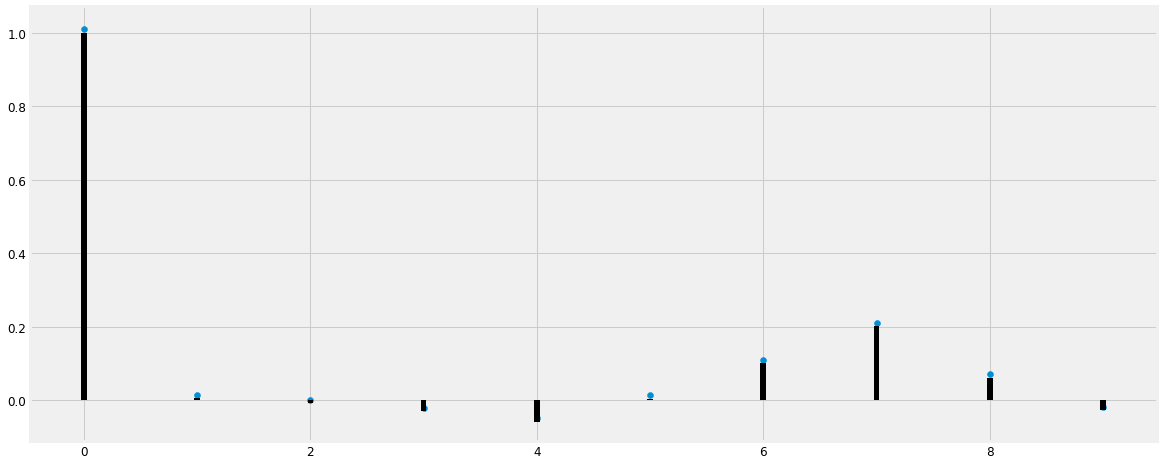

In [72]:
autoco=np.zeros(10)
for i in range(10):
    autoco[i]=results.resid.autocorr(lag=i)
plt.bar(np.arange(10), autoco,width=0.05,color='black')
plt.scatter(np.arange(10),autoco+0.01)

Le plot au-dessus confirme notre suspicion ! Dans un futur modèle, il sera judicieux d'inclure les lags $x_{t-1}$,...,$x_{t-7}$. Egalement un peu d'auto-correlation aux lags 6 et 8 mais ils sont plutôt faibles et se rapprochent de ceux d'un bruit blanc.

## Régression linéaire inspirée d'un AR(7)

Mêmes remarques que pour le magasin 1

In [73]:
df = pd.read_csv("sales_technical_test.csv") 
df['time']=df.timestamp.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [74]:
data2 = {'tot': np.array(df[(df['storeId']==2)].tot)}
data2 = pd.DataFrame(data2, index=df[(df['storeId']==2)].time)

In [75]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months=['January', 'February','March', 'April','May', 'June','July', 'August','September', 'October',
        'November', 'December']
for i, x in enumerate(days):
    data2[x] = (data2.index.get_level_values(0).weekday == i).astype(int)
for i, x in enumerate(months):
    data2[x] = (data2.index.get_level_values(0).month == i+1).astype(int)

### Effet des 7 derniers jours

In [76]:
data2["lag1"]=data2['tot'].shift(1)
data2["lag2"]=data2['tot'].shift(2)
data2["lag3"]=data2['tot'].shift(3)
data2["lag4"]=data2['tot'].shift(4)
data2["lag5"]=data2['tot'].shift(5)
data2["lag6"]=data2['tot'].shift(6)
data2["lag7"]=data2['tot'].shift(7)

In [77]:
data2 = data2.iloc[7:]

### Effet vacances/fêtes de fin d'année

In [78]:
data2['noel']=((data2.index.get_level_values(0).day >= 19) & (data2.index.get_level_values(0).day <= 31) &
               (data2.index.get_level_values(0).month == 12))*1

### Effet gilets jaunes ? :)

In [79]:
data2["gilet"]=((data2.index.get_level_values(0).weekday == 5) & 
       (((data2.index.get_level_values(0).month == 11)&(data2.index.get_level_values(0).day >= 17)) | (data2.index.get_level_values(0).month == 12)) &
       (data2.index.get_level_values(0).year == 2018)|
      ((data2.index.get_level_values(0).weekday == 5) & (data2.index.get_level_values(0).year == 2019)))*1

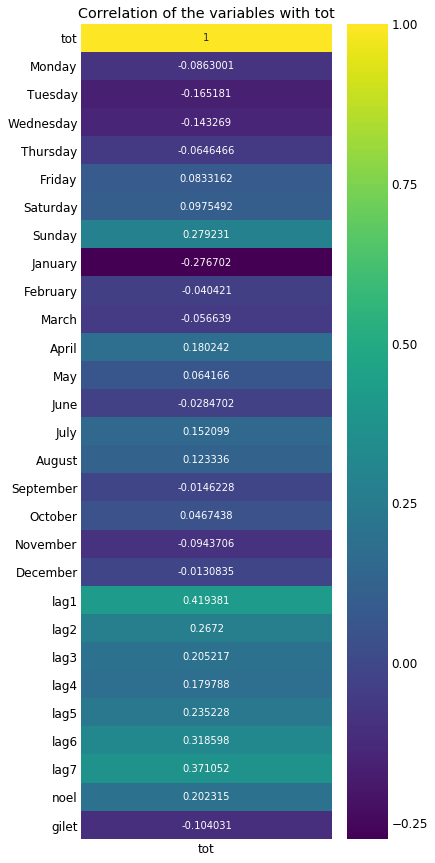

In [80]:
import seaborn as sns
plt.figure(figsize = (5,15))
sns.heatmap(pd.DataFrame(data2.corr()["tot"]),annot=True, fmt="g", cmap='viridis')
plt.title("Correlation of the variables with tot")
plt.show()

Quelques correlations intéressantes : moins d'activité en été qu'au printemps. Plus d'activité le week-end, moins le lundi et le mardi. Un effet positif des gilets jaunes.

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
lm = LinearRegression()
lm.fit(data2.drop('tot', axis=1),data2['tot'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [82]:
model=sm.OLS(data2['tot'],data2.drop('tot', axis=1)).fit()

In [83]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tot   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     20.55
Date:                Sun, 31 Mar 2019   Prob (F-statistic):           5.05e-70
Time:                        13:41:19   Log-Likelihood:                -3410.8
No. Observations:                 754   AIC:                             6876.
Df Residuals:                     727   BIC:                             7000.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Monday        21.2661      4.202      5.060      0.000      13.016      29.517
Tuesday       19.7861      4.130      4.791      0.000      11.679      27.894
Wednesday     20.4912      4.056      5.052      0.000      12.529      28.454
Thursday      26.1999      4.022      6.514      0.000      18.304      34.096
Friday        35.9192      4.074      8.817      0.000      27.921      43.917
Saturday      36.6197      4.218      8.682      0.000      28.339      44.901
Sunday        49.0741      4.145     11.838      0.000      40.936      57.213
January        5.4755      2.627      2.084      0.038       0.318      10.633
February      17.6784      3.313      5.336      0.000      11.174      24.183
March         14.8069      3.280      4.514      0.000       8.367      21.246
April         28.2505      4.036      7.000      0.000      20.328      36.173
May           20.3010      3.837      5.290      0.000      12.767      27.835
June          17.0609      3.335      5.116      0.000      10.514      23.608
July          25.4575      4.018      6.336      0.000      17.570      33.345
August        24.3560      3.962      6.148      0.000      16.578      32.134
September     16.3635      3.443      4.753      0.000       9.604      23.123
October       22.7491      3.453      6.588      0.000      15.970      29.528
November      11.4519      3.384      3.384      0.001       4.808      18.096
December       5.4051      3.718      1.454      0.146      -1.894      12.704
lag1           0.1836      0.037      4.967      0.000       0.111       0.256
lag2           0.0159      0.037      0.428      0.669      -0.057       0.089
lag3           0.0721      0.037      1.946      0.052      -0.001       0.145
lag4           0.0263      0.037      0.715      0.475      -0.046       0.098
lag5           0.0364      0.037      0.994      0.321      -0.036       0.108
lag6           0.1078      0.037      2.950      0.003       0.036       0.180
lag7           0.0340      0.036      0.953      0.341      -0.036       0.104
noel          37.3419      6.383      5.850      0.000      24.811      49.873
gilet        -22.2204      7.505     -2.961      0.003     -36.955      -7.486
==============================================================================
Omnibus:                      116.706   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              548.745
Skew:                           0.613   Prob(JB):                    6.94e-120
Kurtosis:                       6.996   Cond. No.                     6.01e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.27e-26. This might indic

Le tableau de régression rend plus ou moins les mêmes conclusions que le tableau de correlation. Meilleur $R^2$ que pour le model 1 mais quand même assez faible. En revanche les résidus n'ont plus d'autocorrelation à l'ordre 7 (cf ci-dessous) : inclure les lags semble avoir marché, il ne reste plus qu'un bruit blanc.

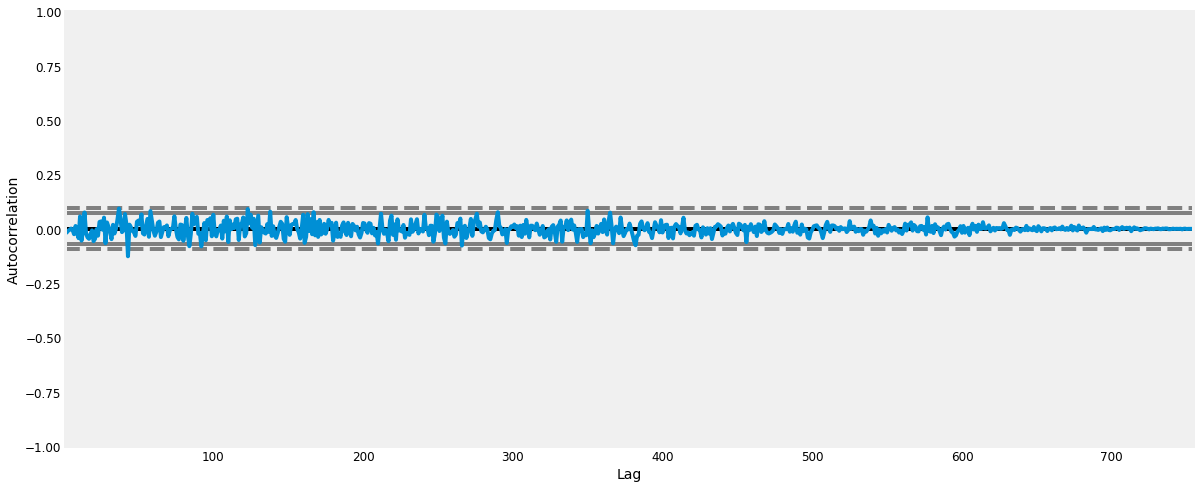

In [84]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(model.resid)

## Fit et prédiction pour le model 1

In [85]:
X_train, X_test, y_train, y_test = train_test_split(data2.drop("tot",1), data2.tot, test_size=0.2)

In [86]:
lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

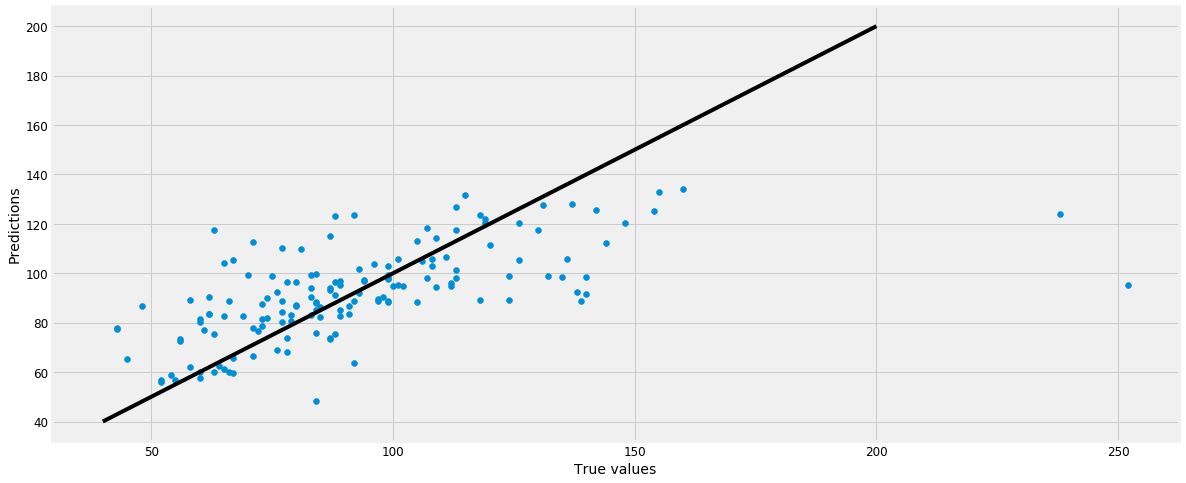

In [87]:
plt.scatter(y_test, predictions)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.plot([40, 200], [40, 200], 'k-')

A première vue, la prédiction semble meilleure que pour le magasin 1. Mauvaise prédiction pour les grosses valeurs de tot (vers 250). Ce sont des valeurs beaucoup plus importantes que les autres. Elles pourraient biaiser le modèle.

In [88]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

Meilleure erreure moyenne, plus faible précision

In [89]:
evaluate(lm,X_test,y_test)

Model Performance
Average Error: 15.7577 degrees.
Accuracy = 82.56%.


82.55777415371531

## Random Forest

Passons maintenant aux choses sérieuses : une random forest. On commence par un model naïf sans tuning :

In [90]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 2000, random_state = 42)

rf.fit(X_train, y_train);

In [91]:
pred2 = rf.predict(X_test)

In [92]:
errors = abs(pred2 - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Mean Absolute Error: 17.22 degrees.
Accuracy: 81.56 %.


Ce n'est pas si mal. Passons maintenat un une 3-fold cross validation

### Cross validation pour random forest

In [93]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [95]:
rf = RandomForestRegressor()

rf_random2 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random2.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   2.3s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   2.3s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 


[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   3.0s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   49.8s


[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=  11.2s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=  11.6s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   3.6s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   6.8s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators

[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total=   7.3s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=   4.8s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=   5.7s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=  10.8s
[CV] n_estimators=

[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   2.4s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   2.4s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=   2.8s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   5.5s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800,

[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   1.6s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   3.6s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   3.5s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   3.5s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=400, 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   5.7s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   5.9s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=  12.5s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   5.4s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimat

[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, total=   5.3s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   7.3s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   4.5s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   7.1s
[CV] n_est

[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total=   2.9s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   1.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   1.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   1.2s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=

[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   1.8s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=   2.3s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   1.3s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   1.2s
[CV] n_estimators=1600, min

[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   1.3s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   1.2s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   7.6s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   8.1s
[CV] n_estimators=2000

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.6min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

Hyper-paramètres optimaux :

In [98]:
rf_random2.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 600}

In [99]:
best_random = rf_random2.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 16.6407 degrees.
Accuracy = 82.21%.


In [103]:
model_final2=rf_random2.best_estimator_.fit(data2.drop("tot",1), data2.tot,)

In [104]:
od = collections.OrderedDict()

od["tot"]=[0]*28
for i in days :
    od[i]=[0]*28
for i in months :
    od[i]=[0]*28
for i in range(7):
    od["lag"+str(i+1)]=[0]*28
od["noel"]=[0]*28
od["gilet"]=[0]*28
od["February"]=[1]*28
x=pd.DataFrame(od)
x.iloc[0]["Friday"]=1
for i in range(np.array(x).shape[0]-1):
    for j in range(np.array(days).shape[0]):
        if x.iloc[i][days[j]]==1:
            x.iloc[i+1][days[(j+1)%7]]=1
x.gilet=(x.Saturday==1)*1

In [105]:
data22=data2.copy()
data22=data22.append(x)

In [112]:
init=754
for j in range(28):
    for i in range(7):
        data22.iloc[init+j,20+i]=data22.iloc[init+j-i-1,0]
    data22.iloc[init+j,0]=model_final2.predict(data22.iloc[init+j,1:29].reshape(1, -1))
    

In [113]:
from datetime import date
from datetime import timedelta
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months=['January', 'February','March', 'April','May', 'June','July', 'August','September', 'October',
        'November', 'December']
a = date(2019,2,1)
numdays = 28
dateList = []
for x in range (0, numdays):
    dateList.append(a + timedelta(days = x))

In [119]:
out2 = collections.OrderedDict()
out2["tot"]=np.array(data22.iloc[754:,0])
out2["storeId"]=np.ones(np.array(data22.iloc[754:,0]).shape[0])*2

In [120]:
out2=pd.DataFrame(out2,index=dateList)
out2.index.name='timestamp'

In [121]:
out2.to_csv(r'magasin2.csv')

## Conclusions

Séries temporelles avec une composante de saisonnalité très forte de période environ 7 jours (ce qui est logique pour un magasin) et avec une légère 'trend' qui fait augmenter les ventes au printemps et les fait réduire l'hiver (surtout pour le magasin 1).
La régression linéaire inspirée d'un AR(7) est plutôt satisfaisant étant donnée la simplicité de ce modèle. La random forest n'a pas fait tellement mieux.

Beaucoup de limitations à ce que j'ai fait : 
- Pour le 2eme magasin, j'aurais probablement dû essayer d'enlever les deux valeurs aberrantes qui clairement se détachent des autres. Elles ont sûrement eu une grande influence sur le modèle final alors qu'elles ne sont vraisemblablement que des exceptions, voire des erreurs de mesure.

- Il serait intéressant de fitter d'autres modèles

- J'aurais dû essayer de récolter des variables météorologiques mais ne connaissant pas la localisation de ces magasins c'est impossible. D'autant plus si ce sont des données fictives :)
